# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [39]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [40]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

In [41]:
image_path = "assets/006656.png"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [42]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

## Plotting

torch.Size([1, 1, 370, 1224])
torch.Size([1, 1, 192, 640])
(1224, 370)


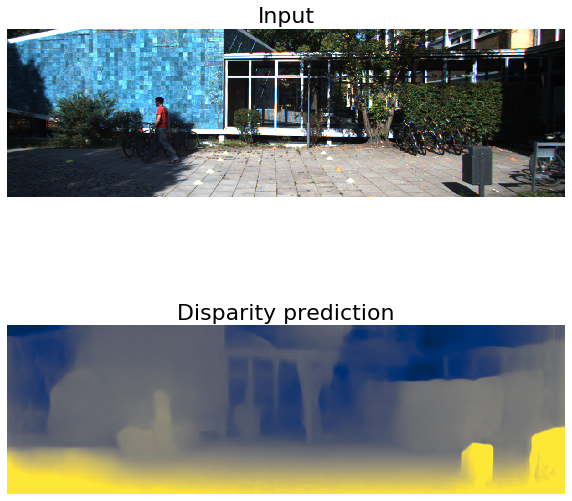

In [43]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)
print(disp_resized.size())
print(disp.size())
print(input_image.size)
# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='cividis', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [44]:
# input_image = np.random(())
MATRIX_P2 = np.array([[719.787081,    0.,            608.463003, 44.9538775],
                      [0.,            719.787081,    174.545111, 0.1066855],
                      [0.,            0.,            1.,         3.0106472e-03],
                      [0.,            0.,            0.,         0]])
print(MATRIX_P2.shape)
int_mat = MATRIX_P2[0:3,0:3]
print(int_mat)
print(disp_resized_np.shape)
points = []
for i in range(disp_resized_np.shape[0]):
    for j in range(disp_resized_np.shape[1]):
        pt = disp_resized_np[i,j]*np.dot(np.linalg.inv(int_mat), np.array([i,j,1]))
        points.append(pt)


(4, 4)
[[719.787081   0.       608.463003]
 [  0.       719.787081 174.545111]
 [  0.         0.         1.      ]]
(370, 1224)


In [48]:
import scipy.io as sio
P = np.array(points)
sio.savemat('points.mat',{'points':P})

In [47]:
import pptk
P = np.array(points)
print(P.shape)
v = pptk.viewer(P) 
v.set(point_size=0.01)

(452880, 3)


KeyboardInterrupt: 